# 1. Collecting the Data


In [1]:
#Import needed libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


C:\Users\Ronan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ronan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Ronan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#Declare desired picture size

image_size = (180, 180)
batch_size = 32

#Load graph data 

graph_train = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/train"
graph_test = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/test"

#Load train and test data
#train_ds and val_ds respectively

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.
Found 65 files belonging to 3 classes.
Using 13 files for validation.


# 2. Preparing the Data

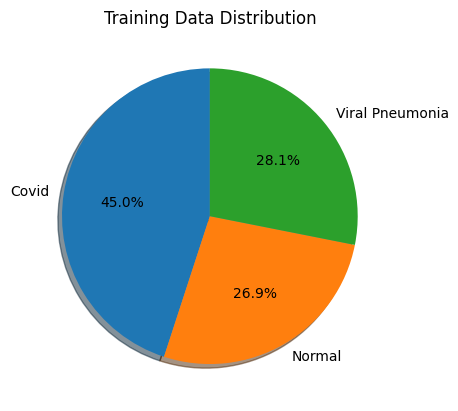

In [3]:
#Show piechart for training data

class_names = os.listdir(graph_train)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(graph_train,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)

ax1.set_title('Training Data Distribution')
plt.show()

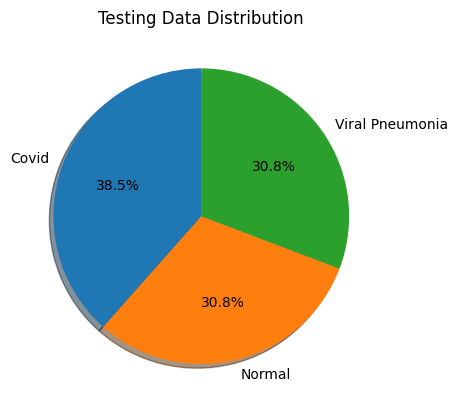

In [4]:
#Show piechart for testing data

class_names = os.listdir(graph_test)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(graph_test,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)

ax1.set_title('Testing Data Distribution')
plt.show()

In [5]:
#Show batch data set 

train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
#Show category of data

class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


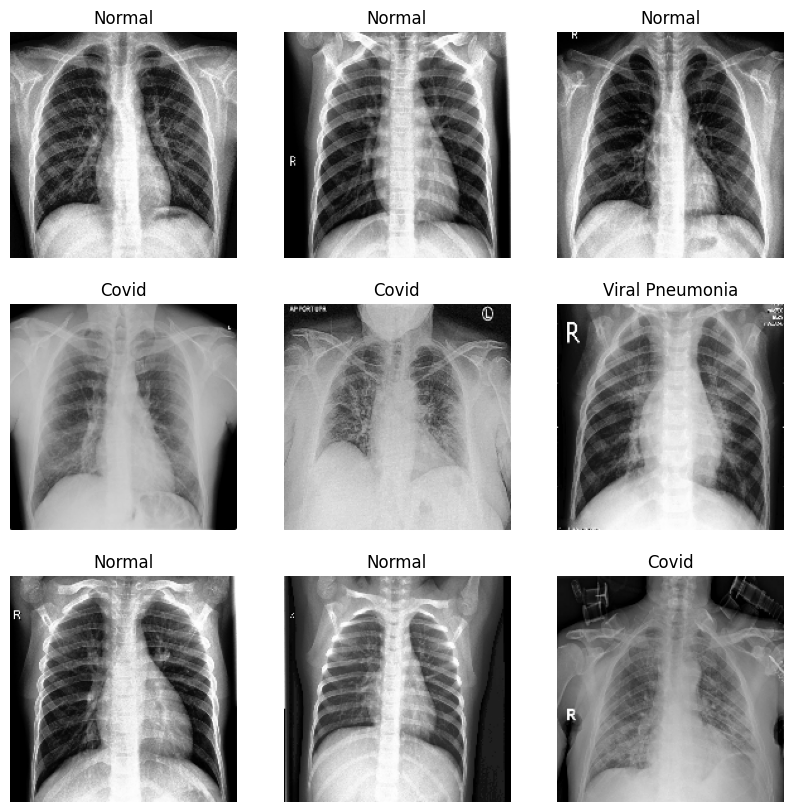

In [7]:
#Show labelled training data 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
#Augment data in different orientation
#Adds more variation in data

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

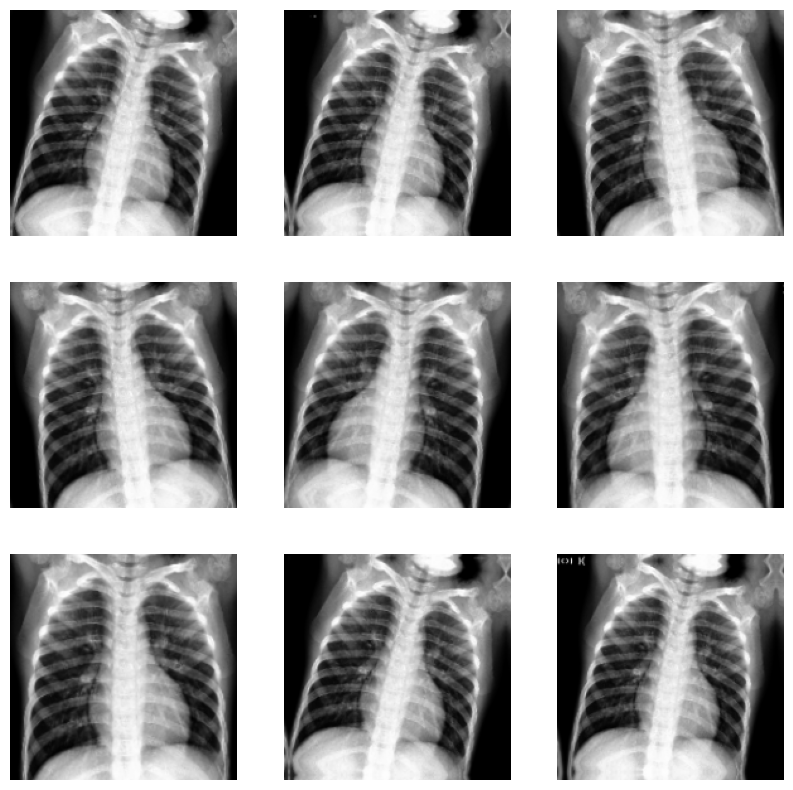

In [9]:
#Show augmented data

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
#Configure performance of dataset 

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# 3-4. Choosing and Training the Model

In [11]:
#Write and define model
#Custom CNN

keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=3)

In [12]:
#Write code for callback

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
#Model Training
#Set 48 epochs for modelling
#categorical cross entropy for classification

epochs = 48

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/48
7/7 [==============================] - 5s 463ms/step - loss: 1.3617 - accuracy: 0.3700 - val_loss: 1.0987 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/48
7/7 [==============================] - 4s 439ms/step - loss: 1.0989 - accuracy: 0.3400 - val_loss: 1.0967 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 3/48
7/7 [==============================] - 4s 436ms/step - loss: 1.0946 - accuracy: 0.4450 - val_loss: 1.0947 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/48
7/7 [==============================] - 4s 439ms/step - loss: 1.0918 - accuracy: 0.4300 - val_loss: 1.0920 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/48
7/7 [==============================] - 4s 436ms/step - loss: 1.0859 - accuracy: 0.4450 - val_loss: 1.0913 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 6/48
7/7 [==============================] - 4s 443ms/step - loss: 1.0767 - accuracy: 0.4500 - val_loss: 1.0912 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 7/48
7/7 [==============================] - 4s 448ms/step - loss: 1.0888 - a

In [18]:
#Printing train and test accuracy
accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("The training accuracy is:", accuracy*100, "%") 
print("The validation accuracy is:", val_accuracy*100, "%") 

The training accuracy is: 94.49999928474426 %
The validation accuracy is: 92.30769276618958 %


# 5. Evaluating the Model


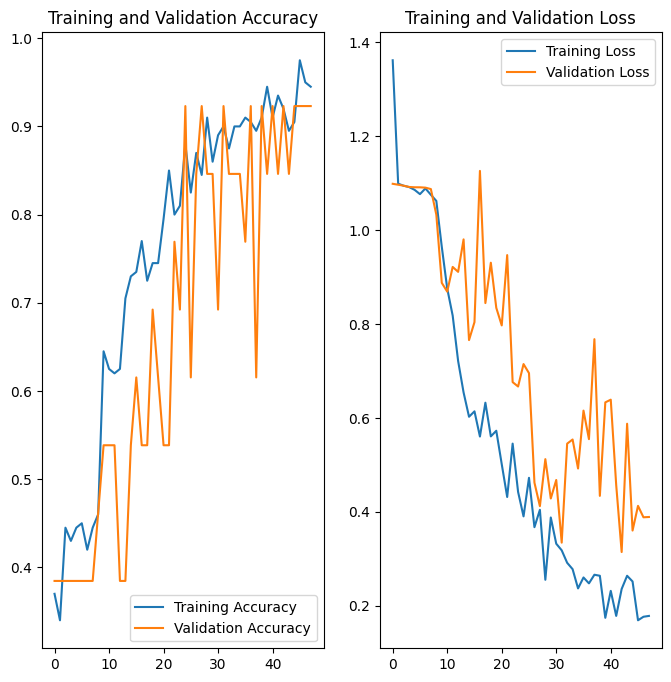

In [15]:
#Create and show graph for training and validation loss and accuracy

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#Define graph parameters

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 6. Making predictions

In [16]:
#Define path for validation data 

image_path = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic1.jpeg"
image_path2 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic2.jpeg"
image_path3 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic3.jpeg"
image_path4 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic4.jpeg"
image_path5 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic5.jpeg"
image_path6 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic6.jpeg"
image_path7 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic7.jpg"
image_path8 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic8.jpeg"
image_path9 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic9.jpeg"
image_path10 = "C:/Users/Ronan/Data Science/Module 1 and 2 Review Materials/Module 4/Covid19-dataset/validation/pic10.jpeg"
merged_path = [image_path,image_path2,image_path3,image_path4,image_path5,image_path6,
               image_path7,image_path8,image_path9,image_path10]

In [17]:
#Make prediction based on validation image
#Define per image which classification is known

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)                  # Create data batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {}"
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to Normal
This image most likely belongs to Covid
This image most likely belongs to Viral Pneumonia
This image most likely belongs to Viral Pneumonia
This image most likely belongs to Normal
This image most likely belongs to Covid
This image most likely belongs to Covid
This image most likely belongs to Viral Pneumonia
This image most likely belongs to Covid
This image most likely belongs to Normal
